In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.signal as signal

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import oe
import utils

In [4]:
date = "20250922" # change this according to ur session
animal = "eb03"

oe_sr = 30000
m_sr = 120

dat_path, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)

acg_path = Path(res_path) / 'acg'
pf_path = Path(res_path) / "pf"
wf_path = Path(res_path) / 'wf_full'

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


In [5]:
goodspiketimes = oe.ks_load(ks_path)

Sup! U have...
59 phy-good clusters


In [6]:
uoi = list(goodspiketimes.keys())
print(uoi)

[595, 597, 601, 607, 609, 613, 615, 619, 621, 623, 633, 637, 641, 645, 647, 651, 659, 663, 667, 671, 681, 683, 687, 707, 709, 715, 717, 719, 721, 731, 734, 738, 742, 744, 750, 752, 754, 758, 760, 768, 782, 798, 815, 819, 852, 858, 860, 862, 864, 866, 882, 886, 894, 900, 901, 910, 912, 913, 914]


In [41]:
# evas manual performance

# pyr = set([15,25,34,49,50,58,62,69,73,74,79,83,116,129,130,140,146,152,153,
#            175,191,201,221,240,268,379,380,401,419,421,431,432,435,448,451,
#            461,463,467,468,481,482,484,499,500,501,502,503,519,521,524,534,535,542,613])
# inter = set([8,12,63,85,94,104,108,161,178,179,188,189,201,213,220,231,255,
#              276,331,480])
# noise = set([81,520])

# pyr = [23,449,471,631,681,683,689,711,744,754,756,768,772,794,830,849,855,866,892,900,923,
#            925,942,947,953,988,990,993,1013,1023,1043,1054,1046]
# inter = [256,287,633,653,658,664,670,697,709,951]
# noise = [126,191,468,470,713,719,784,810,816,820,867,
#              871,879,890,898,933,935,984,966,1009,1018,1027,1035]

# pyr = inter = uoi

# 22sep
pyr = [613,623,637,641,647,651,659,671,683,687,709,715,717,731,734,738,742,752,
       815,852,864,886,900,910,913,914]
pyr_n = [645,667,681,798,815,819,862,858,860,866,894,912]
inter = [595,597,601,607,609,615,619,621,633,663,707,768,782]
noise = [681,719,721,744,750,754,758,760,882,901]

### WF feature

In [7]:
# # Load
# with open(res_path + "/wf_all_expanded.pkl", "rb") as f:
#     wf_all = pickle.load(f)

with open(res_path + "/mean_wf_all_expanded.pkl", "rb") as f:
    mean_wf_all = pickle.load(f)

In [8]:
def extract_waveform_features(waveform, dt=1/30000):
    trough_idx = np.argmin(waveform)
    
    # Find peaks before and after trough
    pre_peak = np.max(waveform[:trough_idx])
    pre_peak_idx = np.argmax(waveform[:trough_idx])
    
    post_peak = np.max(waveform[trough_idx:])
    post_peak_idx = np.argmax(waveform[trough_idx:]) + trough_idx
    
    # Trough-to-peak latency (in ms)
    latency_ms = (post_peak_idx - trough_idx) * dt * 1000
    
    # Peak asymmetry
    asymmetry = (post_peak - pre_peak) / (post_peak + pre_peak + 1e-10)  # small epsilon to avoid division by 0

    return latency_ms, asymmetry

In [9]:
latency_all = []
asymmetry_all = []

for unit in uoi:
    mean_wf = mean_wf_all[unit]
    latency_ms, asymmetry = extract_waveform_features(mean_wf, dt=1/30000)
    latency_all.append(latency_ms)
    asymmetry_all.append(asymmetry)

In [10]:
latency_all = np.array(latency_all)
asymmetry_all = np.array(asymmetry_all)

In [11]:
wf_list = []

for unit in mean_wf_all.keys():
    wf = mean_wf_all[unit]
    l = []
    latency_ms, asymmetry = extract_waveform_features(wf, dt=1/30000)
    l.append(latency_ms); l.append(asymmetry)
    wf_list.append(l)

wf_list = np.array(wf_list)
wf_list.shape

(59, 2)

here if u want u can see how only wf features separate neurons

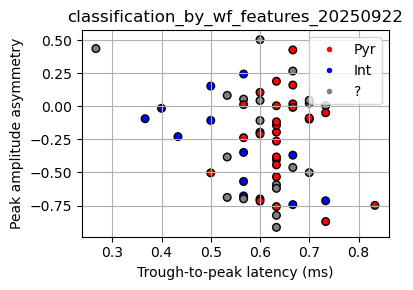

In [42]:
colors = []
for uid in uoi:
    try:
        if uid in pyr:
            colors.append('red')
        elif uid in inter:
            colors.append('blue')
        # elif uid in noise:
        #     colors.append('green')
        else:
            colors.append('gray')  # unknown / unclassified
    except:
        colors.append('gray')


# Plot
plt.figure(figsize=(4,3))
plt.scatter(latency_all, asymmetry_all, c=colors, s=30, edgecolors='k')
plt.xlabel("Trough-to-peak latency (ms)")
plt.ylabel("Peak amplitude asymmetry")
filename = f"classification_by_wf_features_{date}"

plt.title(filename)
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Pyr', markerfacecolor='red', markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', label='Int', markerfacecolor='blue', markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', label='?', markerfacecolor='gray', markersize=5)
])
plt.tight_layout()
plt.savefig(os.path.join(wf_path, filename), dpi=300, bbox_inches='tight')
plt.show()

In [13]:
from sklearn.cluster import KMeans

# Your features
X = np.column_stack((latency_all, asymmetry_all))

# Cluster into 2 groups
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_  # 0 or 1

In [14]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X)
labels_gmm = gmm.predict(X)

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=5).fit(X)
labels_dbscan = dbscan.labels_

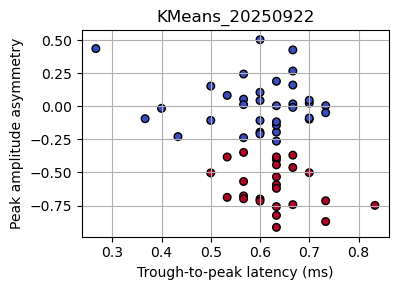

In [16]:
plt.figure(figsize=(4,3))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', s=30, edgecolors='k')
plt.xlabel("Trough-to-peak latency (ms)")
plt.ylabel("Peak amplitude asymmetry")
filename = f"KMeans_{date}"
plt.title(filename)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(wf_path, filename), dpi=300, bbox_inches='tight')
plt.show()

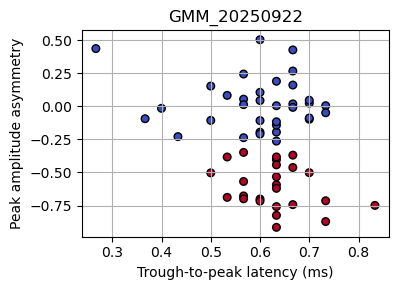

In [17]:
plt.figure(figsize=(4,3))
plt.scatter(X[:, 0], X[:, 1], c=labels_gmm, cmap='coolwarm', s=30, edgecolors='k')
plt.xlabel("Trough-to-peak latency (ms)")
plt.ylabel("Peak amplitude asymmetry")
filename = f"GMM_{date}"
plt.title(filename)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(wf_path, filename), dpi=300, bbox_inches='tight')
plt.show()

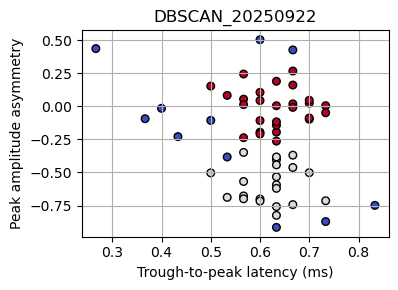

In [18]:
plt.figure(figsize=(4,3))
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap='coolwarm', s=30, edgecolors='k')
plt.xlabel("Trough-to-peak latency (ms)")
plt.ylabel("Peak amplitude asymmetry")
filename = f"DBSCAN_{date}"
plt.title(filename)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(wf_path, filename), dpi=300, bbox_inches='tight')
plt.show()

add ACG features and run glm?

### spatial rate maps feature

bad idea

In [19]:
# ofs = ['of1', 'of2', 'of3']
# rm_dict = {}
# for of in ofs:
#     with open(f"{pf_path}/pf_data_dict_{of}_{date}.pkl", "rb") as f:
#         pf_data_dict = pickle.load(f)
#     rm_dict[of] = pf_data_dict['rm']
# rm_dict

In [20]:
# # Step 1: build valid masks per OF (using the first unit as reference)
# valid_masks = {
#     of: ~np.isnan(next(iter(rm_dict[of].values())).flatten())
#     for of in ofs
# }

# # Step 2–3: clean + concatenate across OFs
# flat_concat_rm = []
# for unit in rm_dict['of1'].keys():
#     # apply masks to each OF, then concatenate
#     cleaned = [rm_dict[of][unit].flatten()[valid_masks[of]] for of in ofs]
#     a = np.concatenate(cleaned)
#     flat_concat_rm.append(a)

# flat_concat_rm = np.vstack(flat_concat_rm)  # force proper 2D array
# print(flat_concat_rm.shape)

In [ ]:
# from sklearn.decomposition import PCA
# import umap

# # umap
# umap_kwargs = dict(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
# reducer = umap.UMAP(**umap_kwargs)
# emb_rm = reducer.fit_transform(flat_concat_rm)

# # pca
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=True, with_std=True)
# Xz = scaler.fit_transform(flat_concat_rm)

# pca = PCA(n_components=0.95, svd_solver='full')  # keep 95% variance (<=73 comps)
# X_pca = pca.fit_transform(Xz)   

/storage3/eva/apps/anaconda3/envs/nma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# colors = []
# for uid in rm_dict['of1'].keys():
#     try:
#         if uid in pyr:
#             colors.append('red')
#         elif uid in inter:
#             colors.append('blue')
#         else:
#             colors.append('gray')  # unknown / unclassified
#     except:
#         colors.append('gray')

# plt.figure(figsize=(4, 3))
# plt.scatter(emb_rm[:,0], emb_rm[:,1], c=colors, s=20, alpha=0.5)
# plt.title('UMAP')
# plt.show()

# plt.figure(figsize=(4, 3))
# plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=20, alpha=0.5)
# plt.title('PCA')
# plt.show()

### acg feature

In [19]:
with open(f"{acg_path}/acg_{animal}_{date}.pkl", "rb") as f:
    acg_dict = pickle.load(f)

In [21]:
acg_arr = []

for unit in acg_dict.keys():
    acg_arr.append(acg_dict[unit]['acg'])

acg_arr = np.array(acg_arr)
acg_arr.shape

(59, 200)

In [22]:
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler

/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
umap_kwargs = dict(n_neighbors=80, min_dist=0.1, metric="cosine", random_state=42)
reducer = umap.UMAP(**umap_kwargs)
emb_acg = reducer.fit_transform(acg_arr)

/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [24]:
umap_kwargs = dict(n_neighbors=80, min_dist=0.1, metric="cosine", random_state=42)
reducer = umap.UMAP(**umap_kwargs)

scale = True

if scale:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xz = scaler.fit_transform(acg_arr)
else:
    Xz =  acg_arr

emb_acg = reducer.fit_transform(Xz)

/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


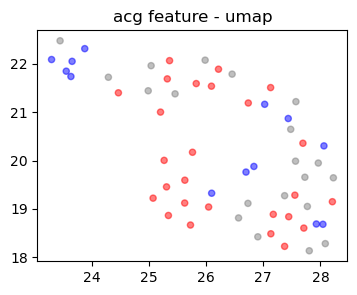

In [43]:
plt.figure(figsize=(4, 3))
plt.scatter(emb_acg[:,0], emb_acg[:,1], c=colors, s=20, alpha=0.5)
plt.title('acg feature - umap')
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler

scale = True

if scale:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xz = scaler.fit_transform(acg_arr)
else:
    Xz =  acg_arr


pca = PCA(n_components=2, svd_solver='full')  
X_pca = pca.fit_transform(Xz)    

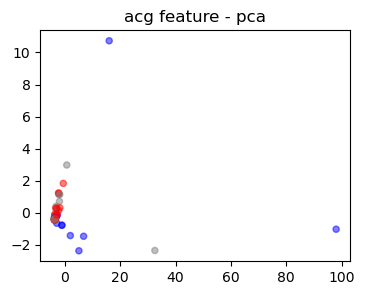

In [44]:
plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=20, alpha=0.5)
plt.title('acg feature - pca')
plt.show()

### fr feature

In [28]:
Clusterinfofile = ks_path+"/cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t')
Clusterinfo

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,group_order,n_spikes,sh
0,0,9.0,58.9,mua,464.060852,95,2595.0,0.732239,noise,4,9169,0.0
1,2,10.5,0.2,good,946.872375,94,2610.0,3.017042,noise,4,37779,0.0
2,3,8.5,52.0,mua,378.744629,95,2595.0,2.095214,noise,4,26236,0.0
3,4,52.1,0.0,good,5817.621582,94,2610.0,0.520050,noise,4,6512,0.0
4,5,9.2,44.0,mua,394.755615,190,2610.0,0.993302,noise,4,12438,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
704,910,11.7,77.4,mua,425.916321,126,3570.0,0.144228,good,4,1806,1.0
705,911,11.7,77.4,mua,425.916321,126,3570.0,0.001118,noise,4,14,1.0
706,912,NaN,NaN,NaN,1011.898743,122,3630.0,0.228480,good,4,2861,1.0
707,913,17.4,82.3,mua,594.465393,24,3660.0,2.050013,good,4,25670,0.0


In [29]:
fr_array = Clusterinfo.set_index("cluster_id").loc[uoi, "fr"].tolist()
fr_array

[2.86826186,
 6.90575809,
 9.90011933,
 10.26771621,
 3.30262193,
 0.40513121,
 7.19956407,
 35.89527972,
 5.50844275,
 0.49034213,
 5.79761683,
 0.63129552,
 0.61596235,
 0.15325188,
 0.30291005,
 0.84348429,
 1.70916974,
 0.62826083,
 0.1196307,
 0.25187933,
 0.12330427,
 0.70524614,
 0.82519628,
 0.65261822,
 0.47556797,
 0.17241835,
 0.62283033,
 1.19702575,
 0.13999507,
 0.31217384,
 0.07442978,
 0.60422289,
 1.57005313,
 0.08521092,
 0.71107594,
 1.04137807,
 0.0454405,
 0.47684574,
 0.03034691,
 0.47540825,
 1.192314,
 2.57357742,
 0.8175297,
 1.04920437,
 1.75788451,
 2.17707112,
 1.01230892,
 20.09508282,
 3.34039584,
 3.81987697,
 0.09998507,
 1.16580038,
 0.41655123,
 0.59543826,
 0.35985043,
 0.14422767,
 0.22848026,
 2.05001342,
 1.89668168]

## Classifier

In [ ]:
# emb_rm, emb_acg, wf_list, fr_array

In [30]:
# X = np.column_stack([emb_rm, emb_acg, wf_list, fr_array]) # with rate maps
X = np.column_stack([emb_acg, wf_list, fr_array]) # with rate maps
X.shape


(59, 5)

### Option 1: GMM

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# --- inputs (your arrays) ---
# emb_rm:   (73,2)
# emb_acg:  (73,2)
# wf_list:  (73,2) -> [latency_ms, asymmetry]
# fr_array: (73,)

# X = np.column_stack([emb_rm, emb_acg, wf_list, np.log1p(fr_array)]) # with rate maps
X = np.column_stack([emb_acg, wf_list, np.log1p(fr_array)]) 

# columns for reference
# cols = ['rm1','rm2','acg1','acg2','lat_ms','asym','logFR']# with rate maps
cols = ['acg1','acg2','lat_ms','asym','logFR']

# --- scale + feature weighting ---
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# weights: emphasize waveform width & firing rate (tune if desired)
# w = np.array([1.0, 1.0, 1.0, 1.0, 2.0, 1.5, 1.8])  # rm, acg, lat, asym, logFR
w = np.array([1.0, 1.0, 2.0, 1.5, 1.8])  # rm, acg, lat, asym, logFR
Xw = Xz * w

# --- GMM model selection (k=2) ---
best_bic, best = np.inf, None
for cov in ['full', 'diag', 'tied', 'spherical']:
    gmm = GaussianMixture(n_components=2, covariance_type=cov, n_init=50, random_state=0)
    gmm.fit(Xw)
    bic = gmm.bic(Xw)
    if bic < best_bic:
        best_bic, best = bic, gmm

labels = best.predict(Xw)                  # 0/1
proba  = best.predict_proba(Xw).max(1)     # confidence per unit

# --- map clusters to IN vs PYR using latency & logFR cues ---
lat_idx   = cols.index('lat_ms')
logfr_idx = cols.index('logFR')
centroids = best.means_                     # in weighted-z space

# score: high logFR & low latency => interneuron
score = (+centroids[:, logfr_idx] - centroids[:, lat_idx])
in_cluster = np.argmax(score)               # cluster id deemed IN
mapped = np.where(labels == in_cluster, 'IN', 'PYR')

# mark uncertain
mapped_prob = np.array(['uncertain' if p < 0.6 else m for m, p in zip(mapped, proba)])

# --- quick summary ---
out = pd.DataFrame(dict(type=mapped_prob, p=proba), index=np.arange(X.shape[0]))
print(out['type'].value_counts(dropna=False))

type
PYR    50
IN      9
Name: count, dtype: int64


In [46]:
out

,type,p
0,IN,0.999983
1,PYR,0.883038
2,IN,0.999765
3,IN,0.999998
4,IN,0.999996
5,PYR,0.999993
6,IN,0.985902
7,IN,1.000000
8,IN,0.999999
9,PYR,0.999995


In [47]:
palette = {'IN':'blue', 'PYR':'red', 'uncertain':'gray'}

c = (out['type']
       .map(palette)
       .fillna('gray')
       .to_list())

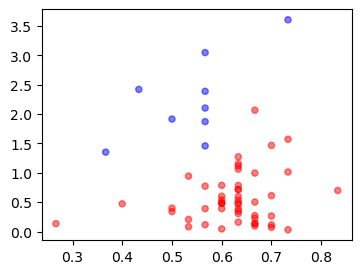

In [48]:
# gmm
plt.figure(figsize=(4, 3))
plt.scatter(wf_list[:,0], np.log1p(fr_array), c=c, s=20, alpha=0.5)
plt.show()

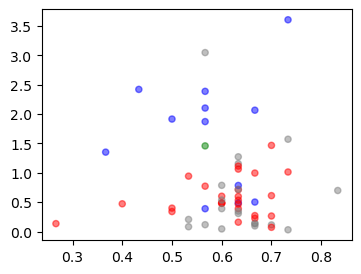

In [69]:
# manual
plt.figure(figsize=(4, 3))
plt.scatter(wf_list[:,0], np.log1p(fr_array), c=colors, s=20, alpha=0.5)
plt.show()

### Option 2 --> Umap on umap

In [36]:
umap_kwargs = dict(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
reducer = umap.UMAP(**umap_kwargs)
emb_meta = reducer.fit_transform(Xz)

/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [55]:
uoi

[595,
 597,
 601,
 607,
 609,
 613,
 615,
 619,
 621,
 623,
 633,
 637,
 641,
 645,
 647,
 651,
 659,
 663,
 667,
 671,
 681,
 683,
 687,
 707,
 709,
 715,
 717,
 719,
 721,
 731,
 734,
 738,
 742,
 744,
 750,
 752,
 754,
 758,
 760,
 768,
 782,
 798,
 815,
 819,
 852,
 858,
 860,
 862,
 864,
 866,
 882,
 886,
 894,
 900,
 901,
 910,
 912,
 913,
 914]

In [58]:
colors = []
for uid in uoi:
    try:
        if uid in pyr & uid!=663:
            colors.append('red')
        elif uid in inter:
            colors.append('blue')
        elif uid==663:
            colors.append('green')
        else:
            colors.append('gray')  # unknown / unclassified
    except:
        colors.append('gray')

In [67]:
u =  609 #663
colors = []
for uid in uoi:
    if uid == u:
        colors.append('green')
    elif uid in pyr and uid != u:
        colors.append('red')
    elif uid in inter:
        colors.append('blue')
    else:
        colors.append('gray')

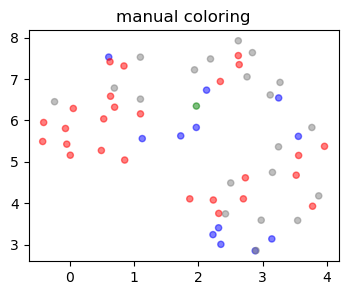

In [68]:
plt.figure(figsize=(4, 3))
plt.scatter(emb_meta[:,0], emb_meta[:,1], c=colors, s=20, alpha=0.5)
plt.title('manual coloring')
plt.show()

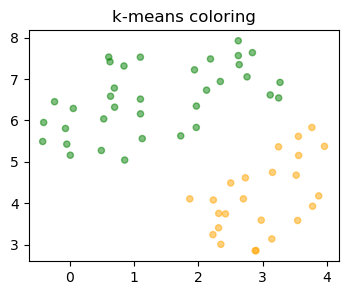

In [51]:
from sklearn.cluster import KMeans

'''
k-means assumes nice spherical blobs and similar cluster sizes - can fail
'''

kmeans = KMeans(n_clusters=2, random_state=0).fit(emb_meta)
labels = kmeans.labels_  # 0 or 1

palette = np.array(['green','orange'])   # 0 -> green, 1 -> orange
colors_meta  = palette[labels]

plt.figure(figsize=(4, 3))
plt.scatter(emb_meta[:,0], emb_meta[:,1], c=colors_meta, s=20, alpha=0.5)
plt.title('k-means coloring')
plt.show()

/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage3/eva/apps/anaconda3/envs/motive/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


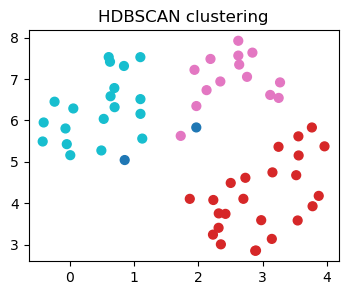

In [52]:
import hdbscan
import matplotlib.pyplot as plt

# Run HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
labels_hdb = clusterer.fit_predict(emb_meta)

# Plot
plt.figure(figsize=(4, 3))
plt.scatter(emb_meta[:,0], emb_meta[:,1], c=labels_hdb, cmap="tab10", s=40)
plt.title("HDBSCAN clustering")
plt.show()

## remove bad cells

In [40]:
# Calculate number of spikes for each unit within each period
with open(Path(res_path) / f"preprocessing/behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

spikes_per_period = {}
for unit, spiketimes in goodspiketimes.items():
    spikes_per_period[unit] = {}
    for period in periods.keys():
        start, end = periods[period][0], periods[period][1]
        # Count spikes within the period
        count = np.sum((spiketimes >= start) & (spiketimes < end))
        spikes_per_period[unit][period] = count

In [41]:
spikes_per_period

{31: {'sl1': np.int64(46046),
  'of1': np.int64(51933),
  'sl2': np.int64(66807),
  'of2': np.int64(52134),
  'sl3': np.int64(52969),
  'of3': np.int64(53891),
  'sl4': np.int64(53286)},
 32: {'sl1': np.int64(31438),
  'of1': np.int64(34826),
  'sl2': np.int64(45355),
  'of2': np.int64(31779),
  'sl3': np.int64(28431),
  'of3': np.int64(29703),
  'sl4': np.int64(25154)},
 61: {'sl1': np.int64(36757),
  'of1': np.int64(41140),
  'sl2': np.int64(53119),
  'of2': np.int64(42928),
  'sl3': np.int64(42475),
  'of3': np.int64(40674),
  'sl4': np.int64(41701)},
 63: {'sl1': np.int64(165),
  'of1': np.int64(56),
  'sl2': np.int64(217),
  'of2': np.int64(78),
  'sl3': np.int64(1651),
  'of3': np.int64(4886),
  'sl4': np.int64(466)},
 78: {'sl1': np.int64(26733),
  'of1': np.int64(31837),
  'sl2': np.int64(41626),
  'of2': np.int64(33212),
  'sl3': np.int64(35133),
  'of3': np.int64(33550),
  'sl4': np.int64(33200)},
 105: {'sl1': np.int64(35582),
  'of1': np.int64(41851),
  'sl2': np.int64(5378

In [42]:
# units where all of periods < 50 spikes
low_spike_units = [
    unit for unit, periods in spikes_per_period.items()
    if all(val < 50 for key, val in periods.items() if key.startswith("of"))
]

print(low_spike_units)

[]


In [43]:
# find indices in uoi
low_spike_indices = [uoi.index(unit) for unit in low_spike_units]

print(low_spike_indices)

[]


In [44]:
labels_hdb

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1])

In [45]:
unit_classes = labels_hdb.copy() 
unit_classes[low_spike_indices] = 2

In [46]:
unit_classes

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1])

In [47]:
label_map = {0: "int", 1: "pyr", 2: "noise"}
unit_class_dict = {unit: label_map[label] for unit, label in zip(uoi, unit_classes)}
print(unit_class_dict)

{31: 'pyr', 32: 'int', 61: 'pyr', 63: 'int', 78: 'int', 105: 'pyr', 109: 'int', 123: 'pyr', 134: 'pyr', 155: 'pyr', 166: 'pyr', 173: 'pyr', 178: 'int', 180: 'pyr', 195: 'pyr', 202: 'int', 255: 'int', 259: 'int', 263: 'pyr', 266: 'pyr', 276: 'pyr', 288: 'pyr', 308: 'pyr', 312: 'pyr', 317: 'pyr', 322: 'int', 332: 'pyr', 339: 'pyr', 357: 'pyr', 400: 'int', 426: 'int', 429: 'int', 433: 'int', 445: 'int', 477: 'int', 494: 'pyr', 498: 'pyr', 507: 'pyr', 513: 'int', 529: 'pyr', 553: 'pyr', 574: 'int', 576: 'pyr', 589: 'pyr', 593: 'pyr', 595: 'int', 596: 'int', 603: 'pyr', 605: 'int', 632: 'pyr', 698: 'int', 725: 'int', 729: 'int', 733: 'int', 735: 'int', 737: 'int', 741: 'int', 751: 'int', 753: 'pyr', 757: 'int', 759: 'int', 763: 'int', 769: 'int', 773: 'int', 777: 'int', 781: 'int', 787: 'int', 789: 'int', 791: 'int', 793: 'int', 795: 'pyr', 797: 'int', 801: 'int', 803: 'pyr', 807: 'pyr', 811: 'int', 817: 'int', 825: 'int', 829: 'int', 831: 'int', 833: 'int', 835: 'int', 841: 'int', 845: 'in

In [48]:
with open(Path(res_path)/ f"unit_classes_{date}.pkl", "wb") as f:
    pickle.dump(unit_class_dict, f)

In [ ]:
pyr = [613,623,637,641,647,651,659,671,683,687,709,715,717,731,734,738,742,752,
       815,852,864,886,900,910,913,914]
pyr_n = [645,667,681,798,815,819,862,858,860,866,894,912]
inter = [595,597,601,607,609,615,619,621,633,663,707,768,782]
noise = [681,719,721,744,750,754,758,760,882,901]